In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import sys
import matplotlib.image as mpimg
from PIL import Image
import scipy
from scipy import ndimage
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

import pickle
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
SAVE_DIR = "images_uploaded/"
DATA_MIXED_SIZE='dataset/mixed_size/'
DATA_FIXED_SIZE="dataset/fixed_sized/"

## This is control your image width and height
resize_width,resize_height = 100, 100 

# at the end and because it rgb images result will be 100 * 100 * 3
image_features  = resize_width * resize_height * 3 

In [3]:
def image_display(image):
    image = mpimg.imread(image)
    imgplot = plt.imshow(image)
    return True

In [4]:
def scale_image(image_0_255):
    """Return a numpy array with scaled image from 0 to 1"""
    
    # Scale pixel intensity to be from 0 - 1
    image_0_1 = np.asarray(image_0_255) / 255
    
    # use just 16 bit for each pixel
    image_0_1 = image_0_1.astype(np.float16)
    
    return image_0_1

In [5]:
def save_fixed_width_and_height_image(open_image, which_dir, image_name):
    '''
    The function used to take a path of image, then compress into some resize_width and resize_height,
    then save the new image into the DATA_FIXED_SIZE (dierction contain just image of specific width and height).
    
    Because we have images of me and other so we have to save into specific "which_dir" direction
    '''
    
    # Read the image
    img = Image.open(open_image)
    
    # Resize the opened image
    img = img.resize((resize_width, resize_width), Image.ANTIALIAS)
    
    # Save the image based on its your image or other image
    img.save(DATA_FIXED_SIZE + which_dir  + '/' + image_name)
    
    return img

In [6]:
def read_mixed_width_and_height_images():
    '''
    The function used to loop over our images, and other images, which have different sizes, then call the method,
    save fixed size image to resize these images to have all the same height and width, to use later in our model, 
    this because any model need specific number of input at the end.
    '''
    try:
        # Get all directions inside this direction actually 2 direction me and other
        dirs                          = os.listdir(DATA_MIXED_SIZE)
        # loop over these direction contain our images and other images
        for dir_path in dirs:
            # Get all images inside the direction
            images      = os.listdir(DATA_MIXED_SIZE + dir_path)
            # Loop over these images to resize each of them then save these resized ones.
            for image_name in images:
                # First get image full path
                open_image    =  DATA_MIXED_SIZE + dir_path + '/' + image_name
                
                # Call the method that resize and save the image
                save_fixed_width_and_height_image(open_image, dir_path, image_name)
                
    # In case of have error throw it into some files in logs direction
    except Exception as e:
        file = open("logs/direction_and_file_handleing_file.log","+a")
        file.write("This error related to function read_mixed_size_images of file Predict Me \n"
                   + str(e) + "\n" + "#" *99 + "\n") # "#" *99 as separated lines
    return True

In [7]:
def one_image_reshape_scale(fixed_resized_image_path):
    '''
    The function used to take fixed resized image, then reshape into vectorized version, 
    instead of shape (resize width , resize height , 3) it will be (resize_width*resize_width*3, 1) as new shape.
    '''
    # Open the image
    image_3d_0_255 = mpimg.imread(fixed_resized_image_path)
    # reshape it into (resize_width*resize_width*3, 1)
    image_0_255_vector = image_3d_0_255.reshape(-1, 1)
    # scale it as it 3d
    image_3d_0_1 = scale_image(image_3d_0_255)
    
    # scale it after reshape
    image_0_1_vector = image_3d_0_1.reshape(-1, 1)
    
    return image_0_1_vector, image_0_255_vector

In [8]:
def load_reshape_scale_all_resized_images(dir_path, image_features):
    '''
    The images we have save are all of fixed size, then we need to load these images,
    but we need to first scale it into 0-1 pixel intensity, reshape(vecotrize all images),
    built 2d matrix, which is of shape:  number of images * number of features(width*height*3).
    '''
    try:
        # Get all saved images from dir_path inside fixed_sized dierction
        images      = os.listdir(DATA_FIXED_SIZE + dir_path)
        
        # Get number of images inside this direction
        dir_m_data = len(images)
        
        # Create 2d matrix of number of images we have and number of features
        all_images = np.zeros((dir_m_data, image_features))
        
        # save each image in one row 
        indx = 0
        
        # loop over these images
        for image_name in images:
            # Read the image using its full path
            fixed_resized_image_path = DATA_FIXED_SIZE + dir_path + '/' + image_name
            
            # reshape and scale the image
            image_0_1_vector, image_0_255_vector = one_image_reshape_scale(fixed_resized_image_path)
            # if some image goes to the fixed image direction wrongly skip them
            if image_0_1_vector.shape[0] ==  image_features:
                all_images[indx] = image_0_1_vector.reshape(-1)
            # To save next image in next row
            indx +=1
    # In case of have error throw it into some files in logs direction
    except Exception as e:
        print("Errrrrrrrrrrror")
        print(e)
        file = open("logs/direction_and_file_handleing_file.log","+a")
        file.write("This error related to function load_reshape_scale_all_resized_images of file Predict Me \n"
                   + str(e) + "\n" + "#" *99 + "\n") # "#" *99 as separated lines
    return all_images, dir_m_data

In [9]:
def images_pipeline():
    '''
    The function used to put all of the work into one place, and return one dataframe at the end, 
    this dataframe contain all of your images vectorized with labels.
    '''


    # Second reshape 3_d images into vector(flatten) and rescale pixel intensity

    load_vectorized_images_of_me_images, dir_m_me       = load_reshape_scale_all_resized_images("me", 
                                                                                                image_features)
    load_vectorized_images_of_other_images, dir_m_other = load_reshape_scale_all_resized_images("other", 
                                                                                                image_features)

    # Third convert numpy 2d array into dataframe
    df_load_vectorized_images_of_me_images               = pd.DataFrame(load_vectorized_images_of_me_images)
    df_load_vectorized_images_of_other_images            = pd.DataFrame(load_vectorized_images_of_other_images)

    # Label images of me as 1 and other as 0
    df_load_vectorized_images_of_me_images['class']      = 1 
    df_load_vectorized_images_of_other_images['class']   = 0
    
    print("I have " + str(len(df_load_vectorized_images_of_me_images)) + " image of me")
    print("="*50)
    print("I have " + str(len(df_load_vectorized_images_of_other_images)) + " image of others")
    
    # combine the two dataframe into one list
    frames                                               = [df_load_vectorized_images_of_me_images , 
                                                            df_load_vectorized_images_of_other_images]

    # concat the frames inside list into dataframe
    df_all_images                                        = pd.concat(frames)
    
    # Shuffle the images
    df_all_images = df_all_images.sample(frac=1).reset_index(drop=True)
    
    print("Now total number of images is " + str(len(df_all_images)))
    
    return df_all_images

In [10]:
#First resize images into specific width and height
#Un comment below line in case you have remove me images and load your images into the same folder
# read_mixed_width_and_height_images()

df_all_images = images_pipeline()

I have 351 image of me
I have 272 image of others
Now total number of images is 623


In [11]:
def load_train_validation_set(df_all_images):
    '''
    The function used to get the data into train and validation set.
    '''
    # Take y outside the dataframe after shuffle
    y = df_all_images['class']
    y = np.array(y)
    y = y.reshape(1, -1)
    print("The shape of y is: ", y.shape)
    
    # Then drop and return the dataframe with out labels (y)
    df_all_images = df_all_images.drop(['class'], axis=1)
    
    # Take part for training and other for validation
    X_train, X_val, y_train, y_val = df_all_images.iloc[:600], df_all_images.iloc[600:], y[:,:600], y[:,600:]
    print("===================Before===================")
    print(X_train.shape)
    print(X_val.shape)
    print(y_train.shape)
    print(y_val.shape)

    # Convert dataframe into numpy array then transpose into features * instances(n*m)
    X_train, X_val = np.array(X_train).T, np.array(X_val).T # T for transpose
    
    print("===================After===================")
    print(X_train.shape)
    print(X_val.shape)
    print(y_train.shape)
    print(y_val.shape)
    
    return X_train, X_val, y_train, y_val

In [12]:
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)

The shape of y is:  (1, 623)
===================Before===================
(600, 30000)
(23, 30000)
(1, 600)
(1, 23)
===================After===================
(30000, 600)
(30000, 23)
(1, 600)
(1, 23)


## Helpful functions

In [13]:
def init_2d_graphs(*colors):
    '''
        Just graph initialize in good way
    '''
    plt.style.use(colors) # color of your 2d graph
    return True

init_2d_graphs('ggplot', 'dark_background' )

True

In [14]:
def display_some_images():

    # X.shape[0] to get number of images we have, then take size of 20 image
    random_indices = np.random.randint(X_train.shape[1], size=20)

    # 50 image with 30000 for each of them
    random_digits_rows = X_train[:, random_indices]
    random_digits_rows = random_digits_rows.T

    # Reshape
    random_images_rows = random_digits_rows.reshape(20, 100, 100, 3)

    # Display the images
    fig, axes = plt.subplots(5,4, figsize=(12,8))

    for i,ax in enumerate(axes.flat):
        ax.imshow(random_images_rows[i])
        ax.axis("off")


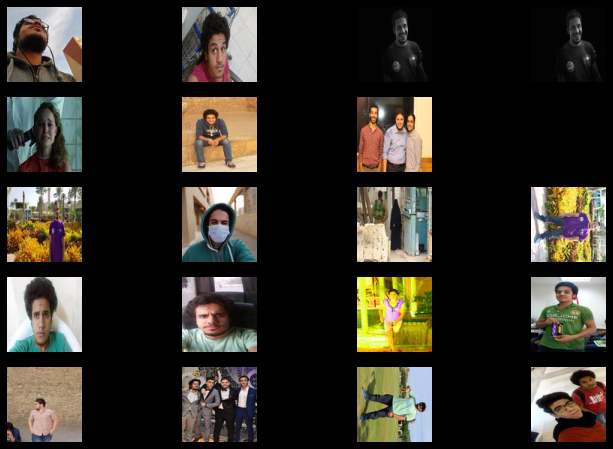

In [15]:
display_some_images()

## Manual Logistic Regression 

This is run logistic regression from scratch.

In [16]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.0
    return w, b

def propagate(w, b, X, Y):
    m, n = X.shape[1], X.shape[0] 
    Z = np.matmul(w.T, X) + b # Prediction
    A = sigmoid(Z)          # map prediction between 0 and 1
    cost = -(1/m) * (np.dot(Y, np.log(A).T) + np.dot((1-Y) , np.log(1-A).T))
    dZ = np.dot(X, (A-Y).T)
    dW = (1/m) * dZ
    dB = (1/m) * np.sum(dZ)
    grads = {"dW": dW,
             "dB": dB}
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dW = grads['dW']
        dB = grads['dB']
        w = w - learning_rate * dW
        b = b - learning_rate * dB
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    params = {"w": w,
              "b": b}

    grads = {"dW": dW,
             "dB": dB}
    return params, grads, costs


def predict(w, b, X):
    m, n = X.shape[0], X.shape[1] 
    Z = np.matmul(w.T, X) + b # Prediction
    A = sigmoid(Z)          # map prediction between 0 and 1
    Y_prediction = 1. * (A > 0.5)
    return Y_prediction


def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    
    w,b  =initialize_with_zeros(X_train.shape[0])
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train,
                                        num_iterations, learning_rate, print_cost=False)
    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test  = predict(w,b,X_val)
    Y_prediction_train = predict(w,b,X_train)
    

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

d = model(X_train, y_train, X_val, y_val, num_iterations = 1000, learning_rate = 0.5, print_cost = True)

[1]


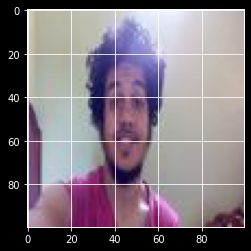

In [23]:
# Example of a picture that was wrongly classified.
index = 1
print(y_val[:,index])
plt.imshow(X_val[:,index].reshape((100, 100, 3)))

In [24]:
X_val[:,index].shape

(30000,)

In [25]:

my_predicted_image = predict(d["w"], d["b"], X_val[:,index].reshape(-1, 1))

print(my_predicted_image)

[[1.]]


[0]


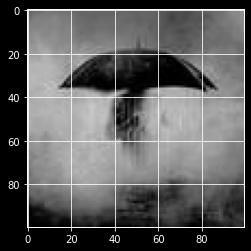

In [26]:
# Example of a picture that was wrongly classified.

index = 7
print(y_val[:,index])
plt.imshow(X_val[:,index].reshape((100, 100, 3)))


In [27]:

my_predicted_image = predict(d["w"], d["b"], X_val[:,index].reshape(-1, 1))

print(my_predicted_image)

[[1.]]


## Train Logstic Model Using Sklearn

In [28]:
X_train, X_val,y_train, y_val = X_train.T, X_val.T, y_train.T, y_val.T

In [29]:
def fit_predict_print_f1_score(model, model_name, X_train=X_train, y_train=y_train):
    
    model.fit(X_train, y_train)  
    predicted              = model.predict(X_train)
    f1_scr                 = f1_score(y_train, predicted)
    print("f1 score on traning with classifer: " + model_name + str(f1_scr))
    print("="*50)
    return model

In [30]:
def grid_search_logistic_regression_ridge_l2_norm(parameters, X_train=X_train, y_train=y_train):
    '''
    The function used to search for best parameter that we can use with Ridge Regression L2,
    to used later for LogisticRegression model with L2 regularization only,
    and related hyper paramter can be used with Ridge Regression L2.
    '''
    
     # First search for best parameter
    log_reg_clf                            = LogisticRegression(penalty="l2", n_jobs=-1)
    grd_serch                              = GridSearchCV(log_reg_clf, parameters, cv=2)
    grd_serch.fit(X_train, y_train)
    
    print("Score: ====================")
    print(grd_serch.best_score_)
    
    print("Best Params: ====================")
    print(grd_serch.best_params_)
    print("="*50)
    
    # return the best best parameter of the Ridge Regression L2
    solver_                                = grd_serch.best_params_['solver']
    max_iter_                              = grd_serch.best_params_['max_iter']
#     tol_                                   = grd_serch.best_params_['tol']
    
    # Create instance of Ridge Regression L2 with best parameter we have found
    trained_logistic_reg_ridge_l2_norm_clf = LogisticRegression(penalty="l2", solver=solver_,
                                                          max_iter=max_iter_, n_jobs=-1)
    
    return trained_logistic_reg_ridge_l2_norm_clf

In [31]:
def train_logistic_classifier(parameters, X_train=X_train, y_train=y_train):
    '''
    The function used to train different logistic classifier based on the Regularization Term (norm_type)
    '''
    
    # For Ridge Regression
    # Search for best parameters with L2 Regression and return LogisticRegression object with these best param
    trained_logistic_reg_ridge_l2_norm_clf = grid_search_logistic_regression_ridge_l2_norm(parameters)

    # The function used to fit any model send to it, then get f1_score and print using this trained model
    trained_logistic_reg_ridge_l2_norm_clf = fit_predict_print_f1_score(trained_logistic_reg_ridge_l2_norm_clf, 
                                                              "Ridge Regression L2 Norm classifier: ")
        
    return trained_logistic_reg_ridge_l2_norm_clf
    


In [32]:
# Paramter for logistic regression l2 norm
logistic_reg_ridge_l2_norm_parameters     = {'solver': ["lbfgs", "liblinear", "saga"],
                                             'max_iter': list(np.linspace(1000, 2000, 3).astype(int)), 
                                             }

# Logistic Regression Classifier Ridge L2 Norm
trained_logistic_reg_ridge_l2_norm_clf    = train_logistic_classifier(logistic_reg_ridge_l2_norm_parameters)


Score: ====================
0.685
Best Params: ====================
{'max_iter': 1000, 'solver': 'lbfgs'}
f1 score on traning with classifer: Ridge Regression L2 Norm classifier: 0.9970760233918129


In [33]:
fit_predict_print_f1_score(trained_logistic_reg_ridge_l2_norm_clf, "Ridge Regression L2 Norm classifier: ",
                           X_val, y_val)

f1 score on traning with classifer: Ridge Regression L2 Norm classifier: 1.0


LogisticRegression(max_iter=1000, n_jobs=-1)

## Let's see this accurate prediction

In [39]:
# X.shape[0] to get number of images we have, then take size of 20 image
images = X_val[:10]
print(images.shape)
print(images[0].shape)
labels = y_val[:10]
predict = trained_logistic_reg_ridge_l2_norm_clf.predict(images).reshape(-1, 1)
print(labels.reshape(-1))
print(predict.reshape(-1))
print((labels == predict).reshape(-1))

# Class 1 means me class 0 means other lets display these 10 images

(10, 30000)
(30000,)
[1 1 0 0 0 0 0 0 0 0]
[1 1 0 0 0 0 0 0 0 0]
[ True  True  True  True  True  True  True  True  True  True]


In [43]:
im = images[0].reshape(1, -1)
print(type(im))
im.shape

(1, 30000)

In [42]:
trained_logistic_reg_ridge_l2_norm_clf.predict()

array([1])

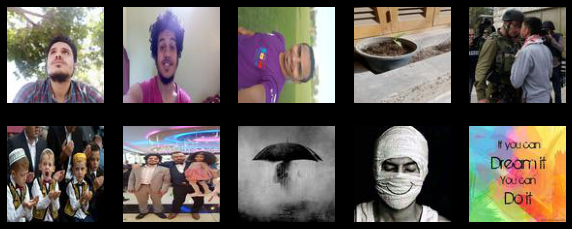

In [36]:
# Reshape
random_images_rows = images.reshape(10, 100, 100, 3)

# Display the images
fig, axes = plt.subplots(2,5, figsize=(10,4))

for i,ax in enumerate(axes.flat):
    ax.imshow(random_images_rows[i])
    ax.axis("off")

In [38]:
# Save logistic Model
filename = 'trained_logistic_reg_ridge_l2_norm_clf.sav'
pickle.dump(trained_logistic_reg_ridge_l2_norm_clf, open("saved_model_weights/" + filename, 'wb'))